In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.spadl.api as spadl

In [2]:
## Configure file and folder names
datafolder = "../data"
statsbomb_json =  os.path.join(datafolder,"statsbomb-root","open-data-master","data")
statsbomb_h5 = os.path.join(datafolder,"statsbomb.h5")
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

### Convert raw Statsbomb json files to Statsbomb HDF5 file

In [3]:
spadl.statsbombjson_to_statsbombh5(statsbomb_json,statsbomb_h5)

...Adding competitions to ../data/statsbomb.h5


...Adding players and teams to ../data/statsbomb.h5:   6%|▌         | 36/637 [00:00<00:01, 349.70it/s]

...Adding matches to ../data/statsbomb.h5


...Adding players and teams to ../data/statsbomb.h5: 100%|██████████| 637/637 [00:27<00:00, 23.02it/s]
converting events files to ../data/statsbomb.h5: 100%|██████████| 637/637 [02:33<00:00,  4.15it/s]


### Inspect StatsBomb HDF5 file

In [4]:
tablenames = ["matches","players","teams","competitions"]
tables = {name : pd.read_hdf(statsbomb_h5,key=name) for name in tablenames}

match_id = tables["matches"].match_id[0]
tables["events"] = pd.read_hdf(statsbomb_h5,f"events/match_{match_id}")

for k,df in tables.items():
    print("#",k)
    print(df.columns,"\n")

# matches
Index(['match_id', 'match_date', 'kick_off', 'competition_id', 'country_name',
       'competition_name', 'season_id', 'season_name', 'home_team_id',
       'home_team_name', 'home_team_gender', 'home_team_group', 'id', 'name',
       'managers', 'away_team_id', 'away_team_name', 'away_team_gender',
       'away_team_group', 'home_score', 'away_score', 'match_status',
       'last_updated', 'data_version', 'shot_fidelity_version', 'match_week',
       'xy_fidelity_version'],
      dtype='object') 

# players
Index(['player_id', 'player_name', 'player_nickname', 'jersey_number',
       'country_id', 'country_name', 'extra'],
      dtype='object') 

# teams
Index(['team_id', 'team_name'], dtype='object') 

# competitions
Index(['competition_id', 'season_id', 'country_name', 'competition_name',
       'competition_gender', 'season_name', 'match_updated',
       'match_available'],
      dtype='object') 

# events
Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', '

### Convert Statsbomb data (in a HDF5 file) to the SPADL format (in a HDF5 file)

In [5]:
spadl.statsbombh5_to_spadlh5(statsbomb_h5,spadl_h5)

  0%|          | 0/636 [00:00<?, ?game/s]

...Converting matches to games
...Converting players
...Converting teams
...Converting competitions
...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Computing playergames (minutes played in each game)


  0%|          | 0/636 [00:00<?, ?game/s]

...Converting events to actions


100%|██████████| 636/636 [06:57<00:00,  1.52game/s]


### Inspect SPADL HDF5 file

In [6]:
tablenames = ["games","players","teams","competitions","actiontypes","bodyparts","results"]
tables = {name : pd.read_hdf(spadl_h5,key=name) for name in tablenames}

game_id = tables["games"].game_id[0]
tables["actions"] = pd.read_hdf(spadl_h5,f"actions/game_{game_id}")

for k,df in tables.items():
    print("#",k)
    print(df.columns,"\n")

# games
Index(['match_id', 'match_date', 'kick_off', 'competition_id', 'country_name',
       'competition_name', 'season_id', 'season_name', 'home_team_id',
       'home_team_name', 'home_team_gender', 'home_team_group', 'id', 'name',
       'managers', 'away_team_id', 'away_team_name', 'away_team_gender',
       'away_team_group', 'home_score', 'away_score', 'match_status',
       'last_updated', 'data_version', 'shot_fidelity_version', 'match_week',
       'xy_fidelity_version', 'game_id'],
      dtype='object') 

# players
Index(['player_id', 'player_name', 'player_nickname', 'jersey_number',
       'country_id', 'country_name', 'extra'],
      dtype='object') 

# teams
Index(['team_id', 'team_name'], dtype='object') 

# competitions
Index(['competition_id', 'season_id', 'country_name', 'competition_name',
       'competition_gender', 'season_name', 'match_updated',
       'match_available'],
      dtype='object') 

# actiontypes
Index(['type_id', 'type_name'], dtype='object') 

# 

### (optional) Plotting actions
Extra library required: ```pip install matplotsoccer```

2018-07-14 Belgium 2-0 England 82'


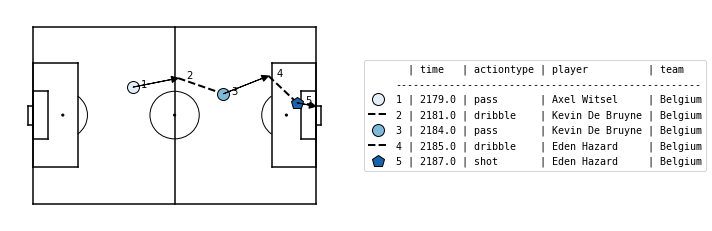

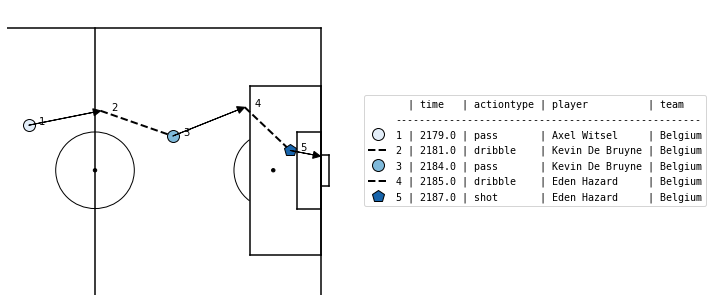

In [8]:
import matplotsoccer

tablenames = [
    "games",
    "players",
    "teams",
    "competitions",
    "actiontypes",
    "bodyparts",
    "results",
]
tables = {name: pd.read_hdf(spadl_h5, key=name) for name in tablenames}

# Select England vs Belgium game at World Cup
games = tables["games"].merge(tables["competitions"])
game_id = games[(games.competition_name == "FIFA World Cup") 
              & (games.away_team_name == "England")
              & (games.home_team_name == "Belgium")].game_id.values[0]

actions = pd.read_hdf(spadl_h5, f"actions/game_{game_id}")
actions = (
    actions.merge(tables["actiontypes"])
    .merge(tables["results"])
    .merge(tables["bodyparts"])
    .merge(tables["players"],"left",on="player_id")
    .merge(tables["teams"],"left",on="team_id")
    .sort_values(["period_id", "time_seconds", "timestamp"])
    .reset_index(drop=True)
)

# use nickname if available else use full name
actions["player"] = actions[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

#shot = 128
shot = 2201
a = actions[shot-4:shot+1]

games = tables["games"]
g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
minute = int((a.period_id.values[0]-1)*45 +a.time_seconds.values[0] // 60) + 1
game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute}'"

print(game_info)

labels = a[["time_seconds", "type_name", "player", "team_name"]]
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=False,
    figsize=6
)
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team=a.team_name,
    result=a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=True,
)